In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# Read the data
df = pd.read_excel('../data/Health_Monitoring_System_Data.xlsx', sheet_name='Sheet1')
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [3]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Heart_Rate      2900 non-null   float64
 1   Blood_Pressure  3000 non-null   int64  
 2   Cholesterol     3000 non-null   int64  
 3   Blood_Sugar     2900 non-null   float64
 4   Risk_Level      3000 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 117.3+ KB


In [4]:
# Check the missing values
df.isnull().sum()

Heart_Rate        100
Blood_Pressure      0
Cholesterol         0
Blood_Sugar       100
Risk_Level          0
dtype: int64

In [5]:
 # print the rows with missing values
df[df.isnull().any(axis=1)]


,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
63,NaN,109,189,NaN,Low
79,NaN,99,178,NaN,High
82,NaN,97,175,NaN,Medium
147,NaN,114,231,NaN,Medium
163,NaN,110,208,NaN,Medium
...,...,...,...,...,...
2822,NaN,138,243,NaN,High
2835,NaN,135,218,NaN,Low
2872,NaN,134,150,NaN,High
2955,NaN,84,191,NaN,Medium


In [6]:
# split the df into two dfs based on the missing values
df_regression = df.dropna().drop(['Heart_Rate'], axis=1)
df_null = pd.get_dummies(df[df.isnull().any(axis=1)].drop(['Heart_Rate'], axis=1))

df_regression.head()

,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,138,234,82.0,Medium
1,85,210,109.0,Medium
2,120,158,137.0,High
3,118,155,111.0,Medium
4,83,184,88.0,Medium


In [7]:
# check the df_null
df_null.head()

,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level_High,Risk_Level_Low,Risk_Level_Medium
63,109,189,NaN,0,1,0
79,99,178,NaN,1,0,0
82,97,175,NaN,0,0,1
147,114,231,NaN,0,0,1
163,110,208,NaN,0,0,1


In [8]:
# Split the data into train and test
X = pd.get_dummies(df_regression.drop(['Blood_Sugar'], axis=1))
y = df_regression['Blood_Sugar']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# find the best k
def find_best_k(X_train, y_train, X_test, y_test, k_range=(1, 40)):
    error_rate = []
    for i in range(k_range[0], k_range[1]):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error_rate.append(np.sqrt(mean_squared_error(y_test, pred_i)))

    plt.figure(figsize=(10, 6))
    plt.plot(range(k_range[0], k_range[1]), error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('RMSE vs. K Value')
    plt.xlabel('K')
    plt.ylabel('RMSE')
    plt.show()

    # print the best k
    best_k = error_rate.index(min(error_rate)) + 1
    print("Minimum RMSE:", min(error_rate), "at K =", best_k)
    
    return best_k


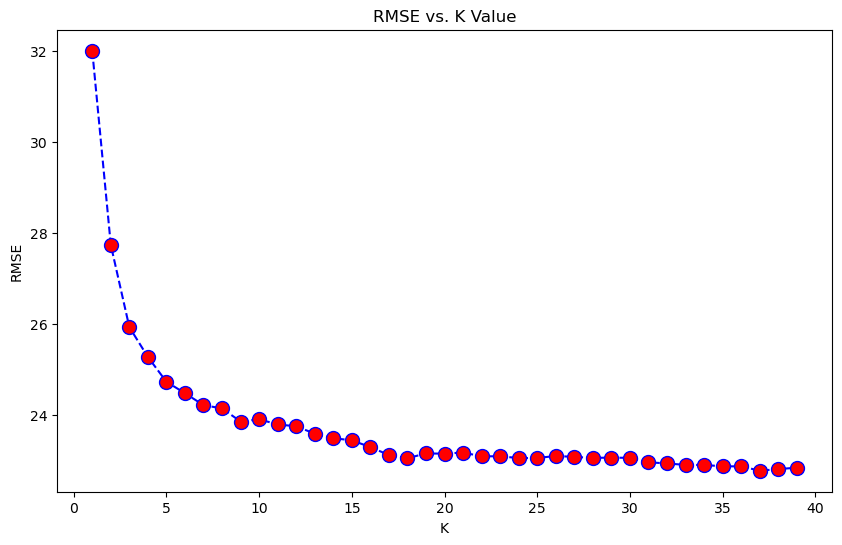

Minimum RMSE: 22.773747318187937 at K = 37


In [10]:
# find the best k for the regression model
best_k_sug = find_best_k(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

In [11]:
# train the model with the best k
knn = KNeighborsRegressor(n_neighbors=best_k_sug)
knn.fit(X_train_reg,y_train_reg)
pred = knn.predict(X_test_reg)
print('RMSE:',np.sqrt(mean_squared_error(y_test_reg,pred)))

# predict the missing values
df_null['Blood_Sugar'] = np.round(knn.predict(df_null.drop(['Blood_Sugar'], axis=1)))
df_null.head()

RMSE: 22.773747318187937


,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level_High,Risk_Level_Low,Risk_Level_Medium
63,109,189,108.0,0,1,0
79,99,178,113.0,1,0,0
82,97,175,115.0,0,0,1
147,114,231,116.0,0,0,1
163,110,208,112.0,0,0,1


In [12]:
# fill the missing values in the original dataframe
df['Blood_Sugar'].fillna(df_null['Blood_Sugar'], inplace=True)
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [13]:
# check df again
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [14]:
# now get the missing values for heart rate
df_hr = df.dropna()
df_hr.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [15]:
# get the rows where heart rate is missing
df_null_hr = df[df.isnull().any(axis=1)].drop(['Heart_Rate'], axis=1)
df_null_hr.head()

,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
63,109,189,108.0,Low
79,99,178,113.0,High
82,97,175,115.0,Medium
147,114,231,116.0,Medium
163,110,208,112.0,Medium


In [16]:
# split the data into train and test
X_hr = pd.get_dummies(df_hr.drop(['Heart_Rate'], axis=1))
y_hr = df_hr['Heart_Rate']

X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(X_hr, y_hr, test_size=0.2, random_state=42)

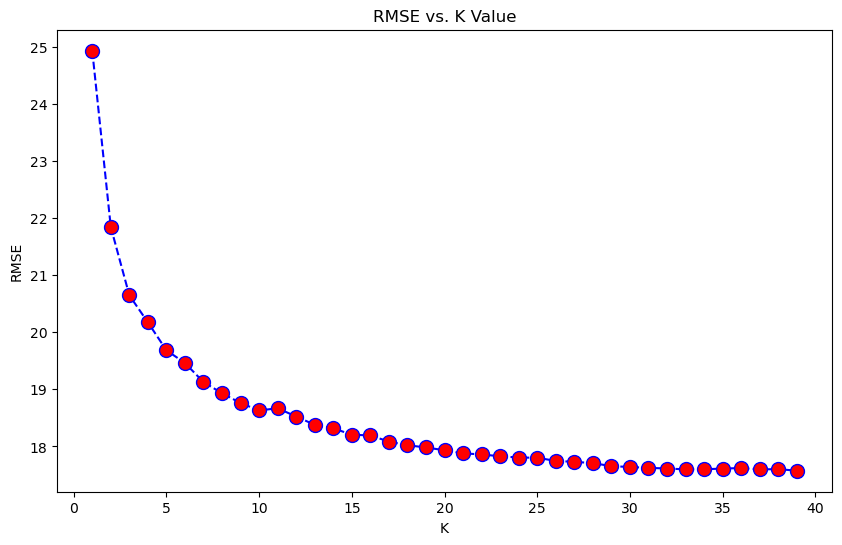

Minimum RMSE: 17.57549608840766 at K = 39
RMSE: 17.57549608840766


,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level,Heart_Rate
63,109,189,108.0,Low,76.0
79,99,178,113.0,High,81.0
82,97,175,115.0,Medium,80.0
147,114,231,116.0,Medium,79.0
163,110,208,112.0,Medium,78.0


In [17]:
# find the best k
best_k_hr = find_best_k(X_train_hr, y_train_hr, X_test_hr, y_test_hr)

# train the model with the best k
knn_hr = KNeighborsRegressor(n_neighbors=best_k_hr)
knn_hr.fit(X_train_hr,y_train_hr)
pred_hr = knn_hr.predict(X_test_hr)
print('RMSE:',np.sqrt(mean_squared_error(y_test_hr,pred_hr)))

# predict the missing values
X_null_hr = pd.get_dummies(df_null_hr)
df_null_hr['Heart_Rate'] = np.round(knn_hr.predict(X_null_hr))
df_null_hr.head()


In [18]:
# fill the missing values in the original dataframe
df['Heart_Rate'].fillna(df_null_hr['Heart_Rate'], inplace=True)
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,Medium
1,101.0,85,210,109.0,Medium
2,78.0,120,158,137.0,High
3,64.0,118,155,111.0,Medium
4,92.0,83,184,88.0,Medium


In [19]:
# null values are filled
df.isnull().sum()

Heart_Rate        0
Blood_Pressure    0
Cholesterol       0
Blood_Sugar       0
Risk_Level        0
dtype: int64

In [20]:
# Risk_Level into numerical values
df['Risk_Level'] = df['Risk_Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df.head()

,Heart_Rate,Blood_Pressure,Cholesterol,Blood_Sugar,Risk_Level
0,88.0,138,234,82.0,1
1,101.0,85,210,109.0,1
2,78.0,120,158,137.0,2
3,64.0,118,155,111.0,1
4,92.0,83,184,88.0,1


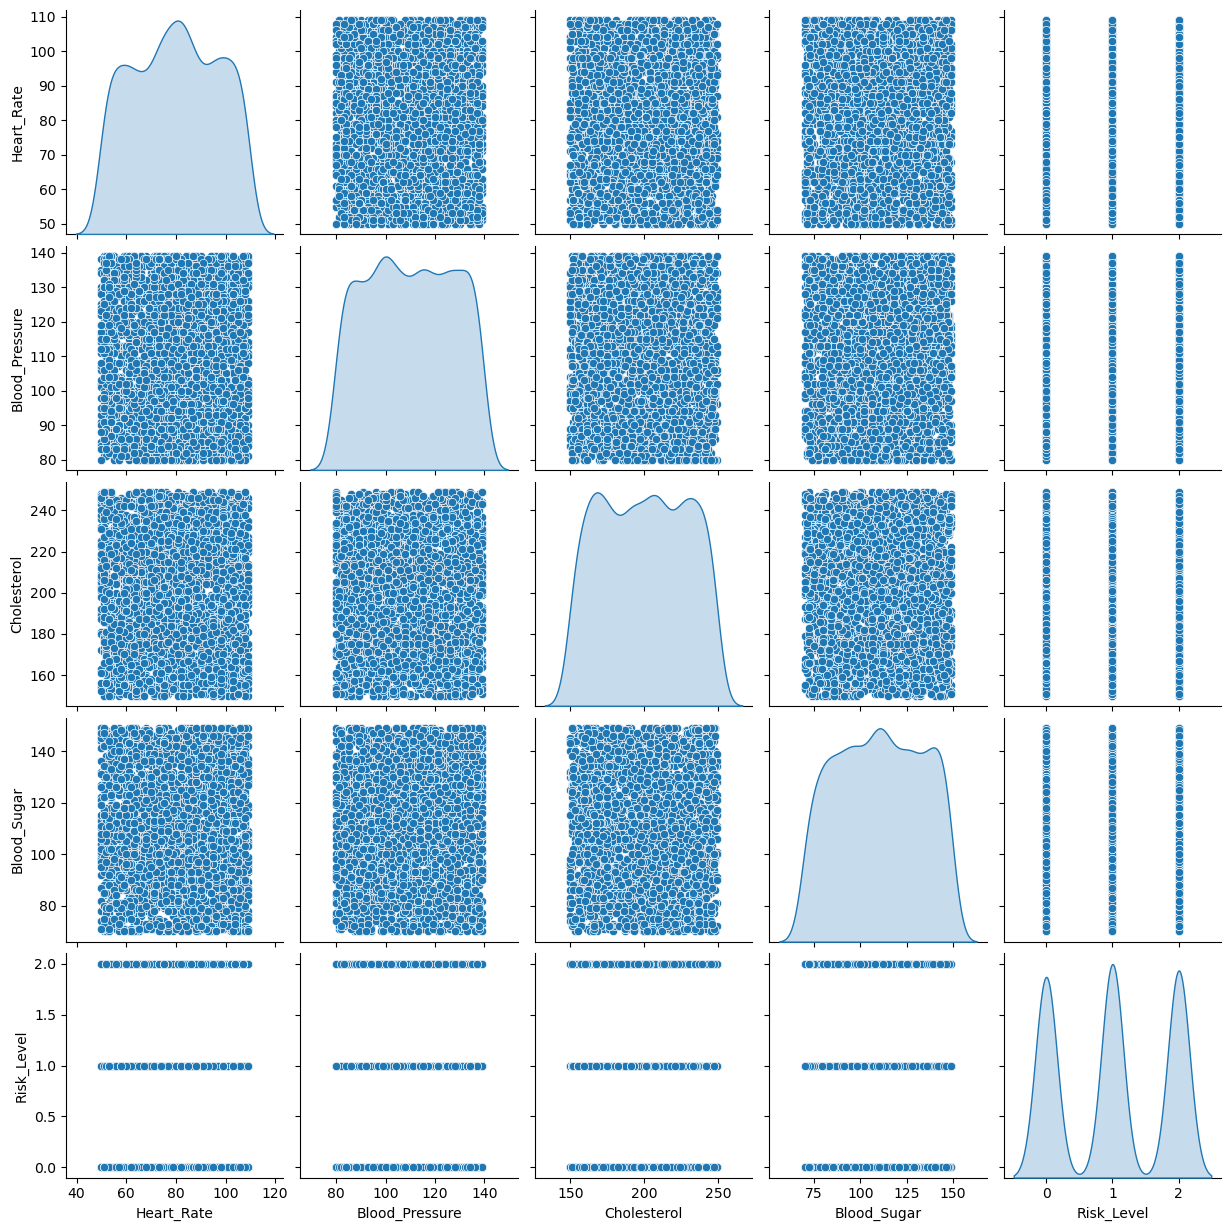

In [21]:
# pairplot
import seaborn as sns
sns.pairplot(df, diag_kind = "kde")

<Axes: >

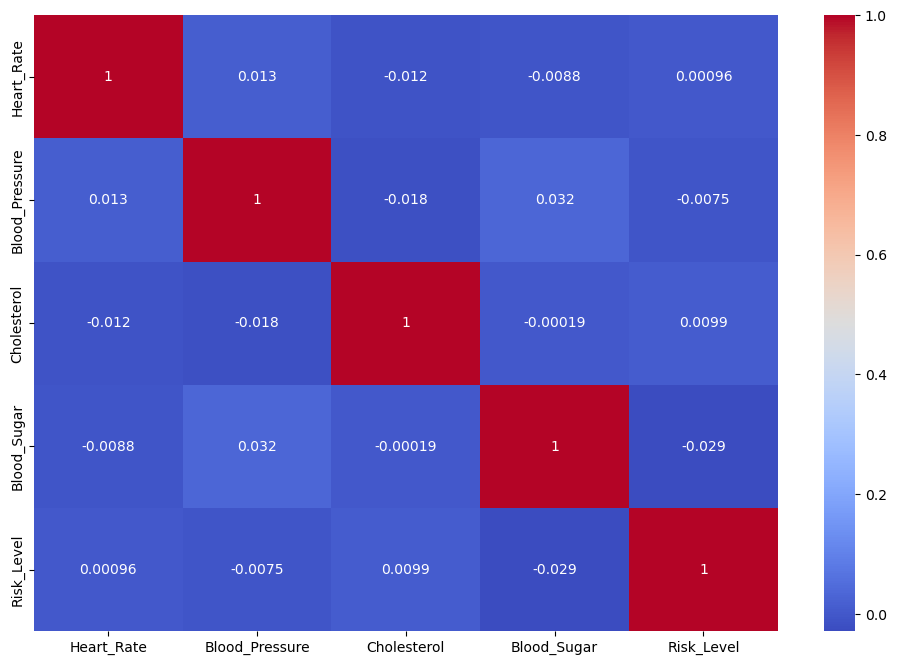

In [22]:
# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [23]:
# create X and y for classification
X = df.drop(['Risk_Level'], axis=1)
y = df['Risk_Level']

In [24]:
from sklearn.preprocessing import MinMaxScaler

# scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = y.values

In [25]:
X

array([[0.6440678 , 0.98305085, 0.84848485, 0.15189873],
       [0.86440678, 0.08474576, 0.60606061, 0.49367089],
       [0.47457627, 0.6779661 , 0.08080808, 0.84810127],
       ...,
       [0.13559322, 0.6440678 , 0.35353535, 0.74683544],
       [0.11864407, 0.25423729, 0.32323232, 0.88607595],
       [0.54237288, 0.54237288, 0.46464646, 0.29113924]])

In [26]:
# split the data into train and test, 90% train, 10% test, due to less data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [27]:
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# import tqdm for progress bar
tqdm.pandas(desc='Running model...')

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed

import time

# function to process each random state and grid search
def process_random_state(model, X, y, param, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
    
    start_time = time.time()
    
    grid = GridSearchCV(model, param, refit=True, verbose=0)
    grid.fit(X_train, y_train)
    
    end_time = time.time()
    duration = end_time - start_time
    
    pred = grid.predict(X_test)
    score = accuracy_score(y_test, pred)
    
    return random_state, score, duration

# function to get the best score based on random state
def get_best_score_based_on_random_state(model, X, y, param, random_state_range=(0, 100)):
    best_score = 0
    best_random_state = 0
    best_duration = float('inf')  # initialize with infinity

    results = Parallel(n_jobs=-1)(  # Use as many CPU cores as available
        delayed(process_random_state)(model, X, y, param, i) for i in tqdm(range(random_state_range[0], random_state_range[1]))
    )

    for random_state, score, duration in results:
        if score > best_score:
            best_score = score
            best_random_state = random_state
            best_duration = duration

    print("Best Score:", best_score, "at random state:", best_random_state, "with duration:", best_duration, "seconds")
    return best_random_state, best_duration, best_score

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
param = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# get the best random state and param
lr_random, lr_time, lr_score = get_best_score_based_on_random_state(lr, X, y, param)


  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: 0.39 at random state: 68 with duration: 0.2952578067779541 seconds


In [32]:
from sklearn import tree

dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
param = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5)
    }
print("Accuracy:", accuracy_score(y_test, y_pred))

# get the best random state and param
dtc_random, dtc_time, dtc_score = get_best_score_based_on_random_state(dtc, X, y, param)

Accuracy: 0.31666666666666665


  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: 0.3933333333333333 at random state: 51 with duration: 9.29625916481018 seconds


In [33]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
param = {
    'var_smoothing': np.logspace(0, -9, num=100),
}
print("Accuracy:", accuracy_score(y_test, y_pred))

# get the best random state and param
gnb_random, gnb_time, gnb_score = get_best_score_based_on_random_state(gnb, X, y, param)

Accuracy: 0.30666666666666664


  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: 0.39666666666666667 at random state: 56 with duration: 2.101076126098633 seconds


In [35]:
from sklearn import svm

svmC = svm.SVC()
svmC.fit(X_train, y_train)
y_pred = svmC.predict(X_test)
param = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
}
print("Accuracy:", accuracy_score(y_test, y_pred))

# get the best random state and param
svmC_random, svmC_time, svmC_score = get_best_score_based_on_random_state(svmC, X, y, param)

Accuracy: 0.37666666666666665


  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: 0.4 at random state: 17 with duration: 27.844303131103516 seconds


In [36]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
param = {
    'n_estimators': [100, 200, 300]
}
print("Accuracy:", accuracy_score(y_test, y_pred))

# get the best random state and param
rfc_random, rfc_time, rfc_score = get_best_score_based_on_random_state(rfc, X, y, param)

Accuracy: 0.3333333333333333


  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: 0.42 at random state: 38 with duration: 8.798995018005371 seconds


In [37]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
param = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
    'max_depth': [3, 4, 5]
}
print("Accuracy:", accuracy_score(y_test, y_pred))

# get the best random state and param
xgb_random, xgb_time, xgb_score = get_best_score_based_on_random_state(xgb, X, y, param)

Accuracy: 0.39


  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: 0.41333333333333333 at random state: 38 with duration: 12.251789093017578 seconds


In [38]:
# KNeighborsClassifie
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
param = {
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
print("Accuracy:", accuracy_score(y_test, y_pred))

# get the best random state and param
knn_random, knn_time, knn_score = get_best_score_based_on_random_state(knn, X, y, param)

Accuracy: 0.3333333333333333


  0%|          | 0/100 [00:00<?, ?it/s]

Best Score: 0.41333333333333333 at random state: 95 with duration: 3.2680351734161377 seconds


In [39]:
# make overall comparison of the models
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM', 'Random Forest', 'XGBoost', 'KNN'],
    'Score': [lr_score, dtc_score, gnb_score, svmC_score, rfc_score, xgb_score, knn_score],
    'Time': [lr_time, dtc_time, gnb_time, svmC_time, rfc_time, xgb_time, knn_time],
    'Random State': [lr_random, dtc_random, gnb_random, svmC_random, rfc_random, xgb_random, knn_random]
})

models.sort_values(by='Score', ascending=False)


,Model,Score,Time,Random State
4,Random Forest,0.420000,8.798995,38
5,XGBoost,0.413333,12.251789,38
6,KNN,0.413333,3.268035,95
3,SVM,0.400000,27.844303,17
2,Naive Bayes,0.396667,2.101076,56
1,Decision Tree,0.393333,9.296259,51
0,Logistic Regression,0.390000,0.295258,68


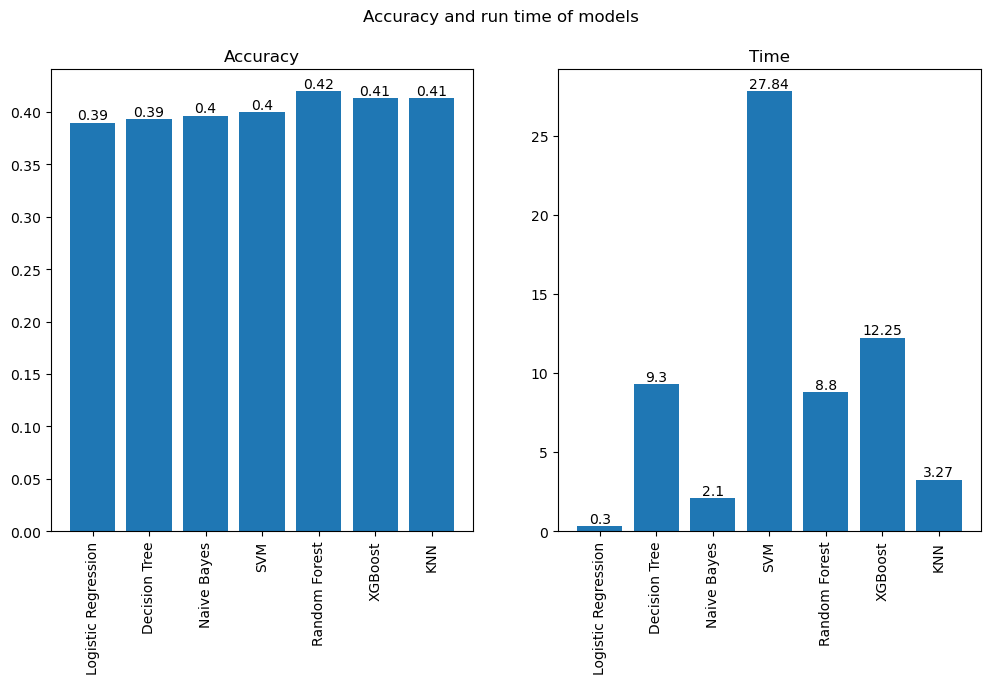

In [56]:
# Accuracy and Time of models
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.suptitle('Accuracy and run time of models')

# Plot the Accuracy
plt.subplot(1, 2, 1)
score_bar = plt.bar(models['Model'], models['Score'])
plt.title('Accuracy')
plt.xticks(rotation=90)

# Add the score values on top of the bars
for bar in score_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot the Time
plt.subplot(1, 2, 2)
time_bar = plt.bar(models['Model'], models['Time'])
plt.title('Time')
plt.xticks(rotation=90)

# Add the time values on top of the bars
for bar in time_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
